In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_COAD = pd.read_csv("Poore_COAD", index_col=0)
Poore_COAD

,g__Cobetia,g__Ammonifex,g__Owenweeksia,g__Haloplasma,g__Desulfosarcina,g__Asaia,g__Parvibaculum,g__Neosynechococcus,g__Zymomonas,g__Kutzneria,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s13008,0.549996,3.627426,1.243335,0.200708,-0.019726,1.143794,3.529965,1.626574,-0.920077,2.144134,...,36.0,0.14,1.80,147.30,RNA,NaN,NaN,NaN,2009.0,Alive
s12994,1.036992,2.472233,1.813183,0.705863,-0.388531,1.448203,1.290475,2.069139,-0.342958,0.201402,...,110.0,0.15,1.72,132.38,RNA,NaN,NaN,NaN,2006.0,Dead
s13005,0.391081,4.148250,3.489199,0.059951,-1.034442,2.387254,3.451919,3.745155,0.596093,1.140453,...,137.0,0.17,1.80,583.30,RNA,NaN,NaN,NaN,2002.0,Dead
s12987,0.307795,1.743036,2.668948,-0.023334,-1.117728,2.303968,0.561278,1.339942,-1.072154,1.057168,...,158.0,0.14,1.80,438.30,RNA,NaN,NaN,NaN,2007.0,Alive
s12895,1.091898,2.527139,1.868089,2.345731,1.251338,1.503109,1.345381,2.124045,-0.288051,2.578236,...,114.0,0.13,1.80,533.30,RNA,NaN,NaN,NaN,2009.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s13862,0.955064,2.390305,1.731255,0.623935,1.114504,3.688203,1.208548,1.987211,-0.424885,1.704437,...,110.0,0.15,1.73,239.76,RNA,NaN,NaN,NaN,2009.0,Alive
s13849,2.017887,1.819532,0.994857,4.463031,-1.705226,0.955917,0.587535,1.494217,-1.100823,0.819574,...,129.0,0.15,1.80,877.30,RNA,NaN,NaN,NaN,2009.0,Alive
s13857,3.343320,2.743249,2.314112,1.020499,3.378589,1.981555,1.969840,2.411123,0.229642,-0.189119,...,36.0,0.14,1.70,19.80,RNA,951909FD-4B2B-4D3F-918A-34269D0A70FC,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive


In [3]:
class_counts = Poore_COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Metastatic                1
Recurrent Tumor           1
Name: count, dtype: int64


In [4]:
Poore_COAD = Poore_COAD[Poore_COAD['sample_type'] != 'Metastatic']
Poore_COAD = Poore_COAD[Poore_COAD['sample_type'] != 'Recurrent Tumor']
class_counts = Poore_COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Name: count, dtype: int64


In [5]:
# Prepare features and target variable
X = Poore_COAD.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_COAD['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2]


In [6]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(2475, 1170)
(2475,)


In [7]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.1, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

c:\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(2475, 469)

Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
Best Score: 0.9907581083107061
Test Set Accuracy: 0.9865410497981157


<Figure size 800x600 with 0 Axes>

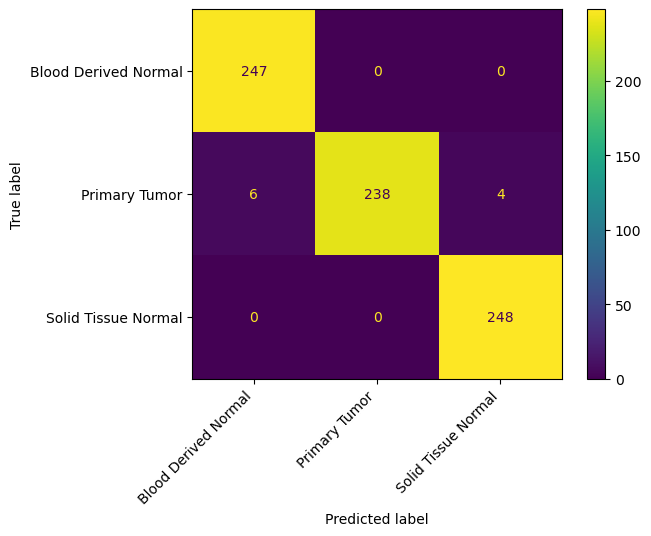

                      precision    recall  f1-score   support

Blood Derived Normal       0.98      1.00      0.99       247
       Primary Tumor       1.00      0.96      0.98       248
 Solid Tissue Normal       0.98      1.00      0.99       248

            accuracy                           0.99       743
           macro avg       0.99      0.99      0.99       743
        weighted avg       0.99      0.99      0.99       743



In [8]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
print(report)

In [9]:
from sklearn.metrics import roc_auc_score

# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
y_score = best_xgb_model.fit(X_train, y_train).predict_proba(X_test)

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_12596\3634286834.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')


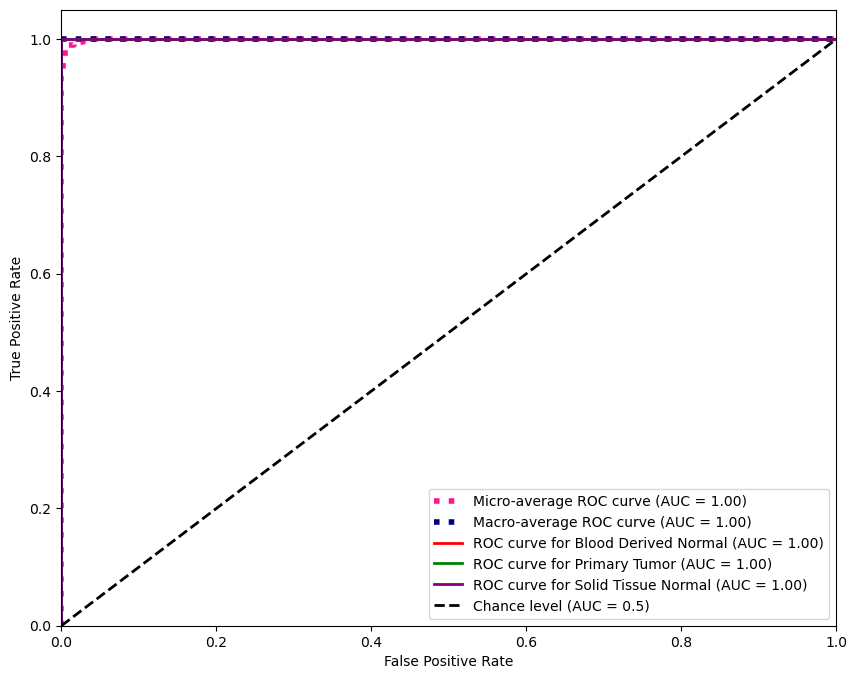

In [10]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=np.arange(3))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['red', 'green', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for {0} (AUC = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2, color='black', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_19028\2875457785.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


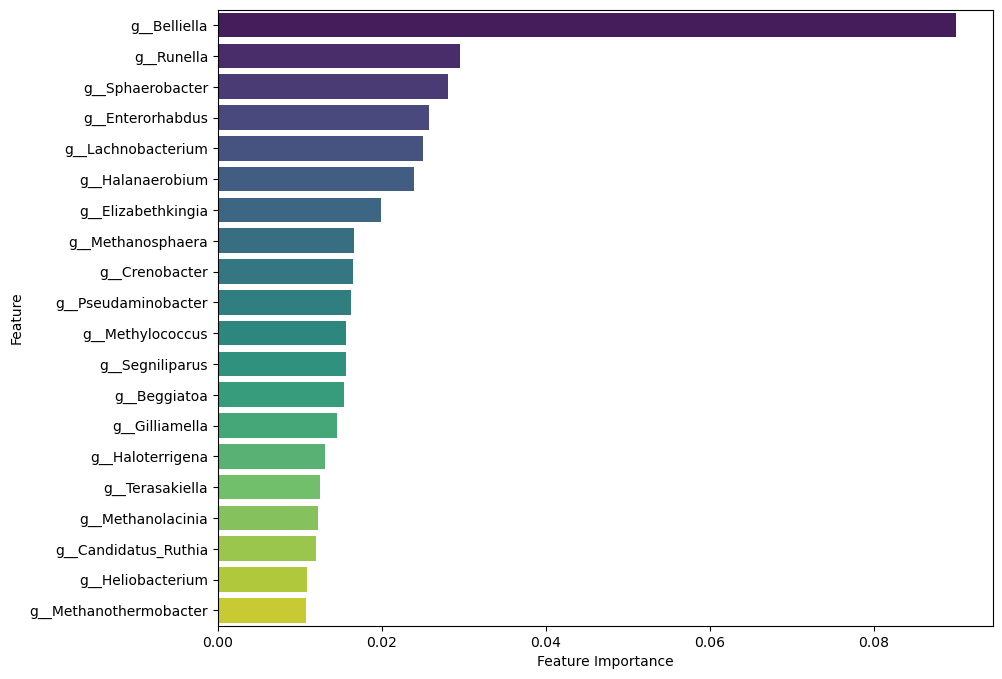

In [11]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

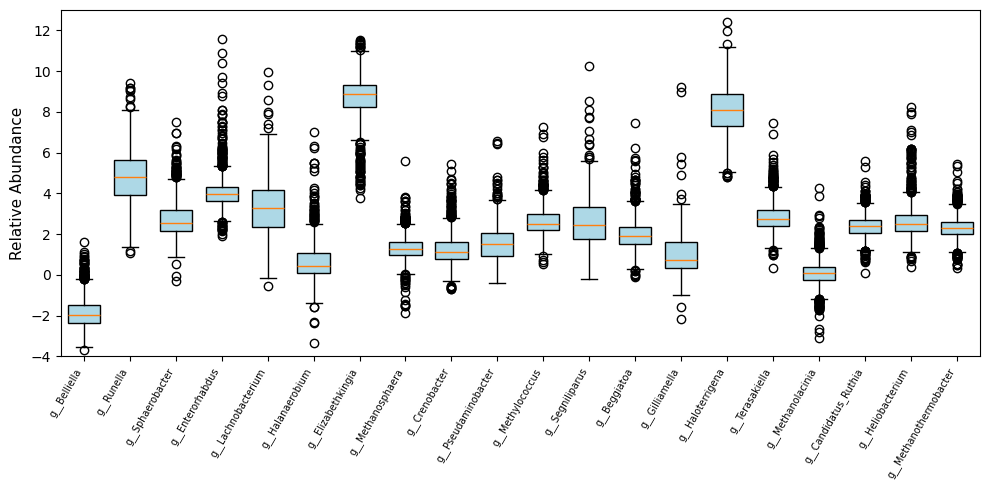

In [12]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 13)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()  
plt.show()